In [ ]:
!pip install --quiet --upgrade tensorflow-federated-nightly
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

import collections
import functools
import io
import os
import requests
import zipfile
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import random

np.random.seed(42)

from google.colab import drive
drive.mount('/content/drive')


     |████████████████████████████████| 821 kB 4.4 MB/s 
     |████████████████████████████████| 126 kB 64.4 MB/s 
     |████████████████████████████████| 53 kB 409 kB/s 
     |████████████████████████████████| 251 kB 49.9 MB/s 
     |████████████████████████████████| 238 kB 27.5 MB/s 
     |████████████████████████████████| 543.3 MB 17 kB/s 
     |████████████████████████████████| 887 kB 40.2 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 121 kB 43.5 MB/s 
     |████████████████████████████████| 65.1 MB 120 kB/s 
     |████████████████████████████████| 4.2 MB 47.0 MB/s 
     |████████████████████████████████| 439 kB 53.4 MB/s 
     |████████████████████████████████| 1.7 MB 46.4 MB/s 
     |████████████████████████████████| 6.0 MB 39.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 r

In [ ]:
def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset], List[tf.data.Dataset]]:

  np.random.seed(42)
  np.random.shuffle(tf_datasets)

  train_buff = int(len(tf_datasets) * train_fraction)
  test_buff = int(len(tf_datasets) * (train_fraction + val_fraction))

  return (tf_datasets[:train_buff], tf_datasets[train_buff:test_buff],
          tf_datasets[test_buff:])

In [ ]:
def create_tf_datasets(data: pd.DataFrame,
                       users_dataset: list,
                       batch_size: int = 1,
                       max_examples_per_user: Optional[int] = None,
                       max_clients: Optional[int] = None) -> List[tf.data.Dataset]:
  num_users = len(list(data.UserID))
  if max_clients is not None:
    num_users = min(num_users, max_clients)

  def rating_batch_map_fn(rating_batch):
    return collections.OrderedDict([
        ("x", tf.cast(rating_batch[:, 1:2], tf.int64)),
        ("y", tf.cast(rating_batch[:, 2:3], tf.float32))
    ])
  tf_datasets = []
  counter = 0
  for user_id in users_dataset:
    user_ratings_df = data[data.UserID == user_id]
    if user_ratings_df.empty != True:
      tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings_df)
      tf_dataset = tf_dataset.take(max_examples_per_user).shuffle(
          buffer_size=max_examples_per_user, seed=42).batch(batch_size).map(
          rating_batch_map_fn,
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
      tf_datasets.append(tf_dataset)
      counter += 1
      if counter == num_users:
        break
    else:
        user_id -= 1
  return tf_datasets

In [ ]:
class UserEmbedding(tf.keras.layers.Layer):

  def __init__(self, num_latent_factors, **kwargs):
    super().__init__(**kwargs)
    self.num_latent_factors = num_latent_factors

  def build(self, input_shape):
    self.embedding = self.add_weight(
        shape=(1, self.num_latent_factors),
        initializer='uniform',
        dtype=tf.float32,
        name='UserEmbeddingKernel')
    super().build(input_shape)

  def call(self, inputs):
    return self.embedding

  def compute_output_shape(self):
    return (1, self.num_latent_factors)

In [ ]:
def get_matrix_factorization_model(
    num_items: int,
    num_latent_factors: int) -> tff.learning.reconstruction.Model:
  global_layers = []
  local_layers = []

  item_input = tf.keras.layers.Input(shape=[1], name='Item')
  item_embedding_layer = tf.keras.layers.Embedding(
      num_items,
      num_latent_factors,
      name='ItemEmbedding')
  global_layers.append(item_embedding_layer)
  flat_item_vec = tf.keras.layers.Flatten(name='FlattenItems')(
      item_embedding_layer(item_input))

  user_embedding_layer = UserEmbedding(
      num_latent_factors,
      name='UserEmbedding')
  local_layers.append(user_embedding_layer)

  flat_user_vec = user_embedding_layer(item_input)

  pred = tf.keras.layers.Dot(
      1, normalize=False, name='Dot')([flat_user_vec, flat_item_vec])

  input_spec = collections.OrderedDict(
      x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
      y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32))

  model = tf.keras.Model(inputs=item_input, outputs=pred)

  return tff.learning.reconstruction.from_keras_model(
      keras_model=model,
      global_layers=global_layers,
      local_layers=local_layers,
      input_spec=input_spec)

In [ ]:
class RatingAccuracy(tf.keras.metrics.Mean):
  def __init__(self,
               name: str = 'rating_accuracy',
               **kwargs):
    super().__init__(name=name, **kwargs)

  def update_state(self,
                   y_true: tf.Tensor,
                   y_pred: tf.Tensor,
                   sample_weight: Optional[tf.Tensor] = None):
    absolute_diffs = tf.abs(y_true - y_pred)
    example_accuracies = tf.less_equal(absolute_diffs, 0.5)
    super().update_state(example_accuracies, sample_weight=sample_weight)

In [ ]:
! unzip /content/drive/MyDrive/inz/round_matrix_1.zip
! unzip /content/drive/MyDrive/inz/round_matrix_2.zip
! unzip /content/drive/MyDrive/inz/round_matrix_3.zip
! unzip /content/drive/MyDrive/inz/round_matrix_4.zip
! unzip /content/drive/MyDrive/inz/round_matrix_5.zip

data_list_1 = ['data_200_2.txt', 'data_500_2.txt', 'data_1000_2.txt', 'data_2000_2.txt', 'data_3000_1.txt', 'data_4000_1.txt', 'data_5000_1.txt']
data_list_2 = ['data_200_2.txt', 'data_500_2.txt', 'data_1000_2.txt', 'data_2000_2.txt', 'data_3000_2.txt', 'data_4000_2.txt', 'data_5000_2.txt']
data_list_3 = ['data_200_3.txt', 'data_500_3.txt', 'data_1000_3.txt', 'data_2000_3.txt', 'data_2000_3.txt', 'data_5000_3.txt', 'data_10000_3.txt' ]
data_list_4 = ['data_200_4.txt', 'data_500_4.txt', 'data_1000_4.txt', 'data_2000_4.txt', 'data_2000_4.txt', 'data_5000_4.txt', 'data_10000_4.txt' ]
data_list_5 = ['data_200_5.txt', 'data_500_5.txt', 'data_1000_5.txt', 'data_2000_5.txt', 'data_2000_5.txt', 'data_5000_5.txt', 'data_10000_5.txt' ]

list_of_data = data_list_1 + data_list_2 + data_list_3 + data_list_4 + data_list_5

clients_number = [200, 500, 1000, 3000, 4000, 5000]
counter = 0 

Archive:  /content/drive/MyDrive/inz/round_matrix_1.zip
  inflating: data_3000_1.txt         
  inflating: data_4000_1.txt         
  inflating: data_5000_1.txt         
26953
[<ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', 

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


ModelWeights(trainable=[array([[ 0.04958906, -0.01656139, -0.04236313, ..., -0.00562432,
        -0.03367058,  0.00274514],
       [ 0.01187588, -0.03620769,  0.02936646, ...,  0.00285498,
         0.03526864,  0.04633138],
       [ 0.00293499, -0.03035009,  0.02309963, ..., -0.01789187,
         0.03173912,  0.00477322],
       ...,
       [ 0.03309688, -0.03074169, -0.01847231, ...,  0.00463833,
        -0.01301978, -0.00235558],
       [ 0.03743862,  0.01443711,  0.00067623, ...,  0.01999033,
        -0.021225  , -0.01119313],
       [-0.04600396,  0.00676363, -0.02919079, ..., -0.03232083,
        -0.01471183,  0.01634974]], dtype=float32)], non_trainable=[])
Item variables shape: (5000, 50)
Initial Eval: OrderedDict([('loss', 11.134126), ('rating_accuracy', 0.0)])
Train metrics: OrderedDict([('rating_accuracy', 0.0), ('loss', 10.893426)])
Train round 0: OrderedDict([('rating_accuracy', 0.0), ('loss', 11.057581)])
Train round 1: OrderedDict([('rating_accuracy', 0.0), ('loss', 11.02

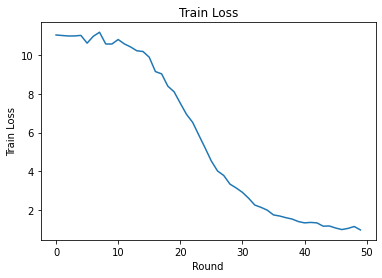

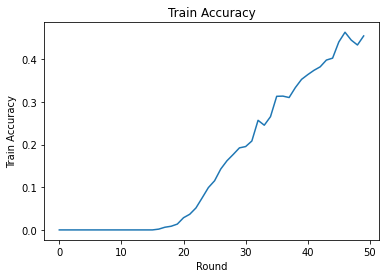

25209
[<ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)),

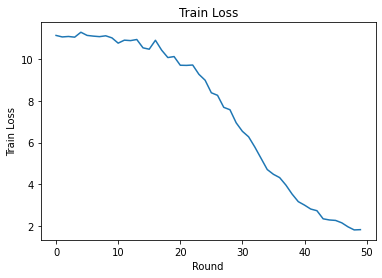

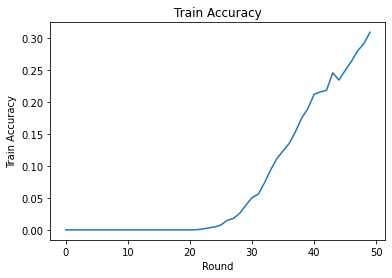

25209
[<ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>, <ParallelMapDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)),

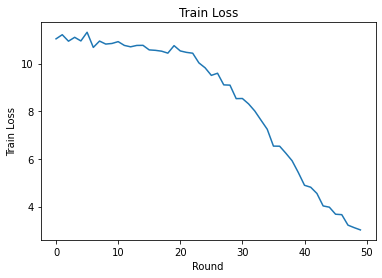

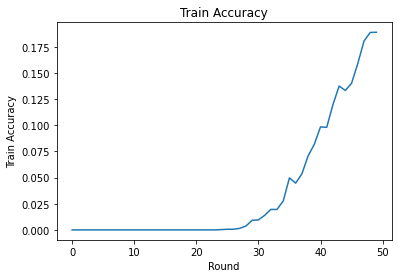

In [ ]:
for x in list_of_data:

  data_from_file = pd.read_csv(x, header = None, names = ['UserID', 'Rating', 'data', 'MovieID'],  dtype = {'UserID': int, 'Rating': int, 'data': str, 'MovieID': int})
  data_from_file = data_from_file.sample(frac=1).reset_index(drop=True)

  data_from_file.iloc[0]

  data_from_file.dropna(inplace = True)
  data_from_file = data_from_file.drop('data', axis=1)
  data_from_file = data_from_file.iloc[:, [0,2,1]]

  users = list(data_from_file.UserID)

  tf_datasets = create_tf_datasets(
      data=data_from_file,
      users_dataset=users,
      batch_size=5,
      max_examples_per_user=200,
      max_clients=1995)

  tf_train_datasets, tf_val_datasets, tf_test_datasets = split_tf_datasets(
      tf_datasets,
      train_fraction=0.8,
      val_fraction=0.1)

  def count_examples(curr_count, batch):
    return curr_count + tf.size(batch['x'])

  model_fn = functools.partial(
      get_matrix_factorization_model,
      num_items=5000,
      num_latent_factors=50)

  loss_fn = lambda: tf.keras.losses.MeanSquaredError()
  metrics_fn = lambda: [RatingAccuracy()]

  training_process = tff.learning.reconstruction.build_training_process(
      model_fn = model_fn,
      loss_fn = loss_fn,
      metrics_fn = metrics_fn,
      server_optimizer_fn = lambda: tf.keras.optimizers.SGD(1.0),
      client_optimizer_fn = lambda: tf.keras.optimizers.SGD(0.5),
      reconstruction_optimizer_fn = lambda: tf.keras.optimizers.SGD(0.1))

  evaluation_computation = tff.learning.reconstruction.build_federated_evaluation(
      model_fn,
      loss_fn = loss_fn,
      metrics_fn = metrics_fn,
      reconstruction_optimizer_fn = functools.partial(
              tf.keras.optimizers.SGD, 0.1))

  state = training_process.initialize()
  print(state.model)

  eval_metrics = evaluation_computation(state.model, tf_val_datasets)
  print('Podstawowoe Eval:', eval_metrics['eval'])

  federated_train_data = np.random.choice(tf_train_datasets, size=50, replace=False).tolist()
  state, metrics = training_process.next(state, federated_train_data)
  print(f'Metryki danych treningowych:', metrics['train'])

  rounds = 2

  train_losses = []
  train_accs = []

  state = training_process.initialize()

  for i in range(rounds):
    federated_train_data = np.random.choice(tf_train_datasets, size=50, replace=False).tolist()#
    state, metrics = training_process.next(state, federated_train_data)
    print(f'Runda {i}:', metrics['train'])
    train_losses.append(metrics['train']['loss'])
    train_accs.append(metrics['train']['rating_accuracy'])
    with open('/content/drive/MyDrive/inz/matrix_1.txt', 'a') as write_to_file:
      write_to_file.write("%s\n" % str(str(clients_number[counter]) + ", " + str(i) + ", " + str(metrics['train']['loss']) + ", " + str(metrics['train']['rating_accuracy'])))

  eval_metrics = evaluation_computation(state.model, tf_val_datasets)
  print('Ostateczny wynik:', eval_metrics['eval'])

  plt.plot(range(rounds), train_losses)
  plt.ylabel('Funkcja kosztu')
  plt.xlabel('Round')
  plt.title('Funkcja kosztu')
  plt.show()

  plt.plot(range(rounds), train_accs)
  plt.ylabel('Dokładność')
  plt.xlabel('Runda')
  plt.title('Dokładność')
  plt.show()

  counter += 1